### Build text classification models using PyTorch
- Load data into pandas dataframe
- Encode categorical label values into integer type
- Split data into train and test subset using 80/20 ratio
- Use TfidfVectorizer to transform input texts into tfidf encoded float point matrix
- Build and train models
- Evaluate model performace

In [2]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from torch import optim
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
torch.__version__

'1.5.1'

##### Load data into pandas dataframe

In [3]:
df = pd.read_csv('bbc-text.csv')
print(df.shape, df['category'].nunique())
df.head(2)

(2225, 2) 5


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...


#### Encode categorical label values into integer type

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(df["category"])
df['encoded_cat'] = le.transform(df['category'])

In [5]:
df.head(2)

,category,text,encoded_cat
0,tech,tv future in the hands of viewers with home th...,4
1,business,worldcom boss left books alone former worldc...,0


#### Split data into train and test subset using 80/20 split, we will train model using train data and test the model using test dataset

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    df['text'], df['encoded_cat'], test_size=.2, stratify=df['category'], random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1780,) (445,) (1780,) (445,)


#### Use TfidfVectorizer to transform input texts into tfidf encoded float point matrix

In [7]:
vectorizer = TfidfVectorizer()

# Learn vocabulary from training texts and vectorize training texts.
x_train = vectorizer.fit_transform(x_train)

# Vectorize test texts.
x_test = vectorizer.transform(x_test)

#### Convert tfidf sparse matrix into pytorch float type tensor in order to feed into pytorch neural network

In [8]:
x_train = torch.tensor(scipy.sparse.csr_matrix.todense(x_train)).float()
x_test = torch.tensor(scipy.sparse.csr_matrix.todense(x_test)).float()

#### Convert label values into pytorch tensor

In [9]:
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

#### Construct a simple multi-layer perceptions network 

In [57]:
model = nn.Sequential(nn.Linear(x_train.shape[1], 64),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(64, df['category'].nunique()),
                      nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.NLLLoss()

# Forward pass, get our logits
logps = model(x_train)
# Calculate the loss with the logits and the labels
loss = criterion(logps, y_train)

loss.backward()

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.Adam(model.parameters(), lr=0.002)

#### Train the neural network with 300 epochs, store the train and test loss so we can plot the training results

In [58]:
%%time
train_losses = []
test_losses = []
test_accuracies = []

epochs = 50
for e in range(epochs):
    optimizer.zero_grad()

    output = model.forward(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    train_loss = loss.item()
    train_losses.append(train_loss)
    
    optimizer.step()

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()
        log_ps = model(x_test)
        test_loss = criterion(log_ps, y_test)
        test_losses.append(test_loss)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y_test.view(*top_class.shape)
        test_accuracy = torch.mean(equals.float())
        test_accuracies.append(test_accuracy)

    model.train()

    print(f"Epoch: {e+1}/{epochs}.. ",
          f"Training Loss: {train_loss:.3f}.. ",
          f"Test Loss: {test_loss:.3f}.. ",
          f"Test Accuracy: {test_accuracy:.3f}")

Epoch: 1/50..  Training Loss: 1.611..  Test Loss: 1.598..  Test Accuracy: 0.189
Epoch: 2/50..  Training Loss: 1.596..  Test Loss: 1.578..  Test Accuracy: 0.189
Epoch: 3/50..  Training Loss: 1.573..  Test Loss: 1.556..  Test Accuracy: 0.270
Epoch: 4/50..  Training Loss: 1.546..  Test Loss: 1.534..  Test Accuracy: 0.443
Epoch: 5/50..  Training Loss: 1.518..  Test Loss: 1.511..  Test Accuracy: 0.613
Epoch: 6/50..  Training Loss: 1.490..  Test Loss: 1.485..  Test Accuracy: 0.699
Epoch: 7/50..  Training Loss: 1.459..  Test Loss: 1.459..  Test Accuracy: 0.782
Epoch: 8/50..  Training Loss: 1.427..  Test Loss: 1.430..  Test Accuracy: 0.822
Epoch: 9/50..  Training Loss: 1.391..  Test Loss: 1.401..  Test Accuracy: 0.858
Epoch: 10/50..  Training Loss: 1.356..  Test Loss: 1.370..  Test Accuracy: 0.867
Epoch: 11/50..  Training Loss: 1.319..  Test Loss: 1.339..  Test Accuracy: 0.883
Epoch: 12/50..  Training Loss: 1.281..  Test Loss: 1.306..  Test Accuracy: 0.897
Epoch: 13/50..  Training Loss: 1.240.

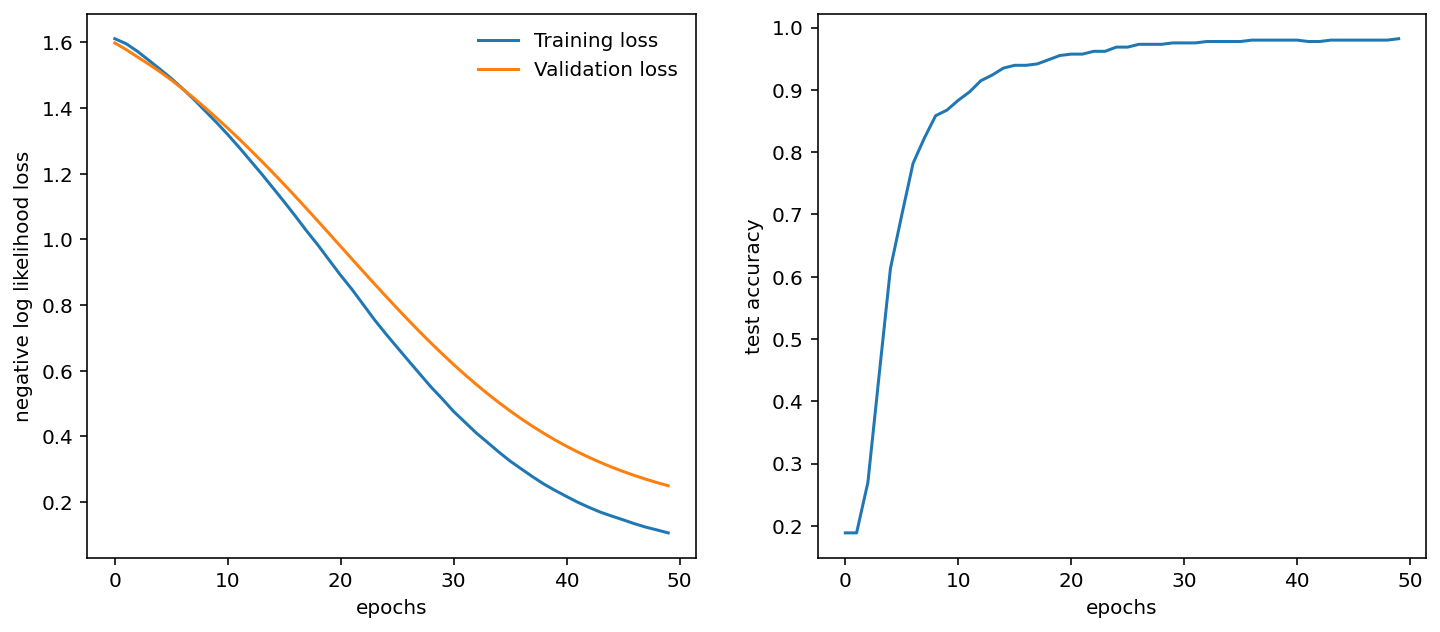

In [59]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
plt.xlabel('epochs')
plt.ylabel('negative log likelihood loss')
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False);
plt.subplot(122)
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.plot(test_accuracies);

### Result:
The training process took less than 3 seconds to complete. After 13 epochs the model has achieved 90% test accuracy and continue to go up to 98.2% at 50 epochs.